### Import all the libraries

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from bs4 import BeautifulSoup

import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

! pip install folium==0.5.0
import folium # plotting library

# Plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Folium installed')
print('Libraries imported.')

     |████████████████████████████████| 79 kB 8.4 MB/s  eta 0:00:01
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=47beb3ad902a4381664947aa340048c9fadb4cfdd6ef50be01b955f2ca7d2a1e
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium
Folium installed
Libraries imported.


In [30]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'KZM2GNARZUMM5KVSMWNYNKGXZOS5Q0VFVLTYIQ2CDNEJXFWD' #Foursquare ID
CLIENT_SECRET = 'CN02IQI4KGGL1Q4HTDD0FZZRKADG2QMGS3FXWHT2GXL3WBOC' #Foursquare Secret
VERSION = '20180604' # Foursquare API version

In [3]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


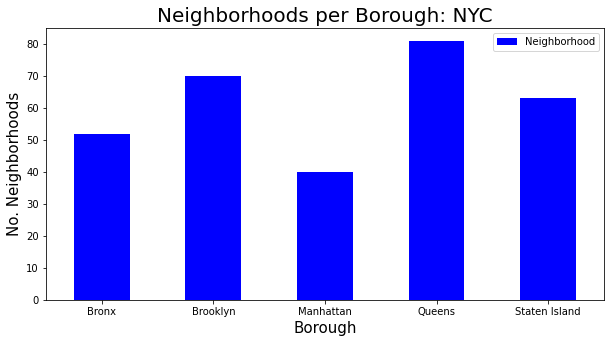

In [4]:
clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [5]:
bronx_data = ny_data[ny_data['Borough'] == 'Bronx'].reset_index(drop=True)
manhattan_data = ny_data[ny_data['Borough'] == 'Manhattan'].reset_index(drop=True)
brooklyn_data = ny_data[ny_data['Borough'] == 'Brooklyn'].reset_index(drop=True)
queens_data = ny_data[ny_data['Borough'] == 'Queens'].reset_index(drop=True)
statenIsland_data = ny_data[ny_data['Borough'] == 'Staten Island'].reset_index(drop=True)
statenIsland_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Staten Island,St. George,40.644982,-74.079353
1,Staten Island,New Brighton,40.640615,-74.087017
2,Staten Island,Stapleton,40.626928,-74.077902
3,Staten Island,Rosebank,40.615305,-74.069805
4,Staten Island,West Brighton,40.631879,-74.107182


function to get the venue details of a given location

In [31]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        results = results["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id'],
            v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue Category Id',
                  'Venue Id']
    
    return(nearby_venues)

In [32]:
def get_rating(locality):
    result=[]
    for i in locality:
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
        query = requests.get(url).json()
        try:
            result.append(query['response']['venue']['rating'])
        except:
            print("The place has not been reviewed")
    return result

In [8]:
bronx_venues = getNearbyVenues(names=bronx_data['Neighborhood'],
                                   latitudes=bronx_data['Latitude'],
                                   longitudes=bronx_data['Longitude'])
bronx_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Category Id,Venue Id
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,4bf58dd8d48988d1d0941735,4c537892fd2ea593cb077a28
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy,4bf58dd8d48988d10f951735,4d6af9426107f04dedeb297a
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy,4bf58dd8d48988d10f951735,5d5f5044d0ae1c0008f043c3
3,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop,4bf58dd8d48988d1c9941735,4c783cef3badb1f7e4244b54
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop,4bf58dd8d48988d148941735,4c25c212f1272d7f836385c5


In [9]:
brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude'])
brooklyn_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Category Id,Venue Id
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa,4bf58dd8d48988d1ed941735,4b895827f964a5206c2d32e3
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop,4bf58dd8d48988d179941735,4ad09cf7f964a520bed820e3
2,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place,4bf58dd8d48988d1ca941735,4a343f1ef964a520f69b1fe3
3,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot,4bf58dd8d48988d143941735,4abe4e84f964a520958c20e3
4,Bay Ridge,40.625801,-74.030621,Georgian Dream Cafe and Bakery,40.625586,-74.030196,Caucasian Restaurant,5293a7d53cf9994f4e043a45,57bf2b24498e2a2800681ed3


In [10]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'])
manhattan_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Category Id,Venue Id
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place,4bf58dd8d48988d1ca941735,4b4429abf964a52037f225e3
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio,4bf58dd8d48988d102941735,4baf59e8f964a520a6f93be3
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner,4bf58dd8d48988d147941735,4b79cc46f964a520c5122fe3
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop,4bf58dd8d48988d148941735,4b5357adf964a520319827e3
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop,4bf58dd8d48988d1e0931735,55f81cd2498ee903149fcc64


In [11]:
queens_venues = getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude'])
queens_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Category Id,Venue Id
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant,4bf58dd8d48988d16b941735,4bdf502a89ca76b062b75d5e
1,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop,4bf58dd8d48988d1f5941735,52c580e8498eddd52d925dd9
2,Astoria,40.768509,-73.915654,Off The Hook,40.767200,-73.918104,Seafood Restaurant,4bf58dd8d48988d1ce941735,514f9fd5e4b023ae1edd4a68
3,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop,4bf58dd8d48988d1f5941735,4a9c0105f964a520b03520e3
4,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym,4bf58dd8d48988d176941735,4c94d26d58d4b60c40fc2b29


In [12]:
statenIsland_venues = getNearbyVenues(names=statenIsland_data['Neighborhood'],
                                   latitudes=statenIsland_data['Latitude'],
                                   longitudes=statenIsland_data['Longitude'])
statenIsland_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Category Id,Venue Id
0,St. George,40.644982,-74.079353,A&S Pizzeria,40.643940,-74.077626,Pizza Place,4bf58dd8d48988d1ca941735,4bb6924c46d4a5938e7ac6c0
1,St. George,40.644982,-74.079353,Beso,40.643306,-74.076508,Tapas Restaurant,4bf58dd8d48988d1db931735,4a214841f964a520cd7c1fe3
2,St. George,40.644982,-74.079353,Staten Island September 11 Memorial,40.646767,-74.076510,Monument / Landmark,4bf58dd8d48988d12d941735,4bf9c5c08d30d13a6bce0218
3,St. George,40.644982,-74.079353,Richmond County Bank Ballpark,40.645056,-74.076864,Baseball Stadium,4bf58dd8d48988d18c941735,4e62c75a483bd9a9747d8cd8
4,St. George,40.644982,-74.079353,Shake Shack,40.643660,-74.075891,Burger Joint,4bf58dd8d48988d16c941735,5df19589ecb0ba00082b90d3


In [13]:
japanese_cat = '4bf58dd8d48988d111941735' # Japanese Restaurant Category Foursquare

In [14]:
japanese_rest_bronx = bronx_venues[bronx_venues['Venue Category Id'] == japanese_cat]
japanese_rest_bronx.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Category Id,Venue Id
797,Belmont,40.857277,-73.888452,Sake II,40.854265,-73.884616,Japanese Restaurant,4bf58dd8d48988d111941735,4baeef6bf964a520cbe23be3


In [15]:
# create map of Japanese restaurants using latitude and longitude values of Bronx
map_bronx = folium.Map(location=[40.837048, -73.865433], zoom_start=10)

# add markers to map
for lat, lng, Venue, neighborhood in zip(japanese_rest_bronx['Venue Latitude'], japanese_rest_bronx['Venue Longitude'], japanese_rest_bronx['Venue'],japanese_rest_bronx['Neighbourhood']):
    label = '{}, {}'.format(Venue, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,
        icon=folium.Icon(color='blue')
        ).add_to(map_bronx) 
    
map_bronx

In [16]:
bronx_rating = get_rating(japanese_rest_bronx['Venue Id'])
bronx_rating

[7.4]

In [17]:
japanese_rest_brooklyn = brooklyn_venues[brooklyn_venues['Venue Category Id'] == japanese_cat]
japanese_rest_brooklyn.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Category Id,Venue Id
365,Manhattan Terrace,40.614433,-73.957438,Masake,40.618227,-73.957961,Japanese Restaurant,4bf58dd8d48988d111941735,4bf890acabdaef3b69b7a184
446,Kensington,40.642382,-73.980421,Sake Sushi,40.644138,-73.976439,Japanese Restaurant,4bf58dd8d48988d111941735,4d5c12a01e43236a87eb1583
541,Prospect Heights,40.676822,-73.964859,Maison Yaki,40.677475,-73.969081,Japanese Restaurant,4bf58dd8d48988d111941735,5cb5e5f9a35f4600255406c6
604,Williamsburg,40.707144,-73.958115,Shalom Japan,40.709219,-73.955839,Japanese Restaurant,4bf58dd8d48988d111941735,51f9b7b3498eefe896caeb23
697,Bedford Stuyvesant,40.687232,-73.941785,Warude,40.684410,-73.944118,Japanese Restaurant,4bf58dd8d48988d111941735,5b3bcb69bfc6d0002ca9bf17


In [18]:
# create map of Japanese restaurants using latitude and longitude values of Brooklyn
map_brooklyn = folium.Map(location=[40.650002, -73.949997], zoom_start=10)

# add markers to map
for lat, lng, Venue, neighborhood in zip(japanese_rest_brooklyn['Venue Latitude'], japanese_rest_brooklyn['Venue Longitude'], japanese_rest_brooklyn['Venue'],japanese_rest_brooklyn['Neighbourhood']):
    label = '{}, {}'.format(Venue, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,
        icon=folium.Icon(color='blue')
        ).add_to(map_brooklyn) 
    
map_brooklyn

In [19]:
brooklyn_rating = get_rating(japanese_rest_brooklyn['Venue Id'])
brooklyn_rating

The place has not been reviewed


[6.1,
 7.5,
 8.3,
 8.2,
 8.3,
 8.2,
 9.1,
 8.8,
 8.8,
 8.6,
 6.8,
 7.0,
 8.8,
 8.8,
 7.0,
 9.0,
 8.2,
 9.0,
 7.9,
 7.5,
 6.5,
 7.4,
 7.0,
 8.3,
 8.3]

In [20]:
japanese_rest_manhattan = manhattan_venues[manhattan_venues['Venue Category Id'] == japanese_cat]
japanese_rest_manhattan.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Category Id,Venue Id
281,Hamilton Heights,40.823604,-73.949688,Geisha Japanese Cuisine,40.824355,-73.951993,Japanese Restaurant,4bf58dd8d48988d111941735,531a0207498e06b4656eb8c5
615,Yorkville,40.775930,-73.947118,Ichiro,40.778901,-73.950843,Japanese Restaurant,4bf58dd8d48988d111941735,4b3fdfc8f964a5200ab125e3
618,Yorkville,40.775930,-73.947118,Inase Sushi,40.774607,-73.950992,Japanese Restaurant,4bf58dd8d48988d111941735,4bc11982b492d13ad88fa560
620,Yorkville,40.775930,-73.947118,Donguri Restaurant,40.775678,-73.952478,Japanese Restaurant,4bf58dd8d48988d111941735,4bd0fe22a8b3a593a123655f
676,Lenox Hill,40.768113,-73.958860,Kome Waza UES,40.765602,-73.957403,Japanese Restaurant,4bf58dd8d48988d111941735,5aa1d85d5f68b931b6f5acda


In [21]:
# create map of Japanese restaurants using latitude and longitude values of Manhattan
map_manhattan = folium.Map(location=[40.78343, -73.96625], zoom_start=10)

# add markers to map
for lat, lng, Venue, neighborhood in zip(japanese_rest_manhattan['Venue Latitude'], japanese_rest_manhattan['Venue Longitude'], japanese_rest_manhattan['Venue'],japanese_rest_manhattan['Neighbourhood']):
    label = '{}, {}'.format(Venue, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,
        icon=folium.Icon(color='blue')
        ).add_to(map_manhattan) 
    
map_manhattan

In [33]:
manhattan_rating = get_rating(japanese_rest_manhattan['Venue Id'])
manhattan_rating

[7.6,
 8.2,
 7.6,
 8.1,
 8.4,
 6.2,
 7.7,
 8.6,
 7.5,
 8.6,
 8.6,
 8.4,
 8.3,
 8.7,
 8.9,
 9.3,
 9.2,
 8.8,
 8.3,
 9.0,
 8.8,
 7.5,
 8.6,
 8.7,
 8.2,
 8.4,
 8.9,
 8.2,
 8.4,
 9.1,
 8.8,
 8.5,
 7.7,
 8.6,
 9.1,
 8.9,
 8.9,
 8.6]

In [23]:
japanese_rest_queens = queens_venues[queens_venues['Venue Category Id'] == japanese_cat]
japanese_rest_queens.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Category Id,Venue Id
27,Astoria,40.768509,-73.915654,Mochiron Izakaya,40.765406,-73.918506,Japanese Restaurant,4bf58dd8d48988d111941735,5c8c36363af988002c811da1
76,Astoria,40.768509,-73.915654,Pink Nori,40.764932,-73.917221,Japanese Restaurant,4bf58dd8d48988d111941735,52e70541498e25eacfde6b47
121,Woodside,40.746349,-73.901842,Matsuri,40.745626,-73.903387,Japanese Restaurant,4bf58dd8d48988d111941735,59cfbbaf491be76b026b6a84
308,Howard Beach,40.654225,-73.838138,Hagane,40.655786,-73.839108,Japanese Restaurant,4bf58dd8d48988d111941735,4c100cd3b93cc9b6482156e0
656,Maspeth,40.725427,-73.896217,Wakamatsu,40.727544,-73.892359,Japanese Restaurant,4bf58dd8d48988d111941735,4c4653d8dd35be9ab0a4ddd8


In [24]:
# create map of Japanese restaurants using latitude and longitude values of Queens
map_queens = folium.Map(location=[40.742054, -73.769417], zoom_start=10)

# add markers to map
for lat, lng, Venue, neighborhood in zip(japanese_rest_queens['Venue Latitude'], japanese_rest_queens['Venue Longitude'], japanese_rest_queens['Venue'],japanese_rest_queens['Neighbourhood']):
    label = '{}, {}'.format(Venue, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,
        icon=folium.Icon(color='blue')
        ).add_to(map_queens) 
    
map_queens

In [34]:
queens_rating = get_rating(japanese_rest_queens['Venue Id'])
queens_rating

[8.4,
 7.6,
 7.2,
 6.7,
 7.4,
 7.8,
 8.0,
 7.2,
 6.4,
 7.9,
 8.8,
 8.7,
 5.9,
 9.3,
 9.0,
 9.1,
 7.4,
 8.0]

In [26]:
japanese_rest_staten = statenIsland_venues[statenIsland_venues['Venue Category Id'] == japanese_cat]
japanese_rest_staten

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Category Id,Venue Id
126,West Brighton,40.631879,-74.107182,Kyoto Sushi 5,40.630824,-74.103289,Japanese Restaurant,4bf58dd8d48988d111941735,4bca626368f976b086615f83
164,Castleton Corners,40.613336,-74.119181,Tokyo Sushi Japanese,40.613121,-74.120907,Japanese Restaurant,4bf58dd8d48988d111941735,4d06abf2c2e5370451f1c467
244,Great Kills,40.549480,-74.149324,Arirang Hibachi Steakhouse,40.549539,-74.150123,Japanese Restaurant,4bf58dd8d48988d111941735,4b747a21f964a520e6de2de3
293,Eltingville,40.542231,-74.164331,Tomo,40.543011,-74.165703,Japanese Restaurant,4bf58dd8d48988d111941735,4b9863e0f964a520a83f35e3
413,Grasmere,40.598268,-74.076674,Fuji Sushi,40.598764,-74.079733,Japanese Restaurant,4bf58dd8d48988d111941735,4bad3dcbf964a520173d3be3
646,Bulls Head,40.609592,-74.159409,Sapporo Sushi,40.607976,-74.163452,Japanese Restaurant,4bf58dd8d48988d111941735,4b79eec8f964a520161b2fe3


In [27]:
# create map of Japanese restaurants using latitude and longitude values of Staten Island
map_staten = folium.Map(location=[40.579021, -74.151535], zoom_start=10)

# add markers to map
for lat, lng, Venue, neighborhood in zip(japanese_rest_staten['Venue Latitude'], japanese_rest_staten['Venue Longitude'], japanese_rest_staten['Venue'],japanese_rest_staten['Neighbourhood']):
    label = '{}, {}'.format(Venue, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,
        icon=folium.Icon(color='blue')
        ).add_to(map_staten) 
    
map_staten

In [35]:
staten_rating = get_rating(japanese_rest_staten['Venue Id'])
staten_rating

The place has not been reviewed


[6.5, 6.8, 7.7, 7.9, 7.0]

In [36]:
import statistics

Rating = []
Rating.append(statistics.mean(bronx_rating))
Rating.append(statistics.mean(brooklyn_rating))
Rating.append(statistics.mean(manhattan_rating))
Rating.append(statistics.mean(queens_rating))
Rating.append(statistics.mean(staten_rating))
Rating

[7.4, 7.976, 8.41842105263158, 7.822222222222222, 7.18]

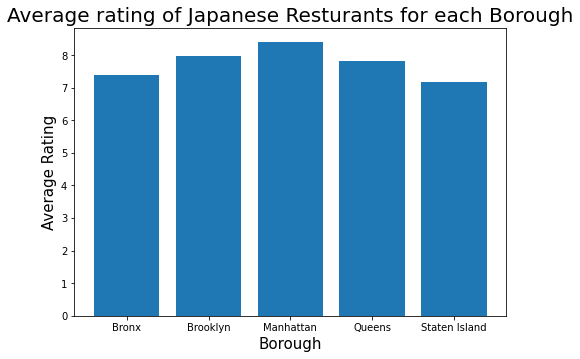

In [37]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
borough = ['Bronx','Brooklyn','Manhattan','Queens','Staten Island']
ax.bar(borough, Rating)
plt.title('Average rating of Japanese Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [38]:
Number =[]
Number.append(len(japanese_rest_bronx))
Number.append(len(japanese_rest_brooklyn))
Number.append(len(japanese_rest_manhattan))
Number.append(len(japanese_rest_queens))
Number.append(len(japanese_rest_staten))
Number

[1, 26, 38, 18, 6]

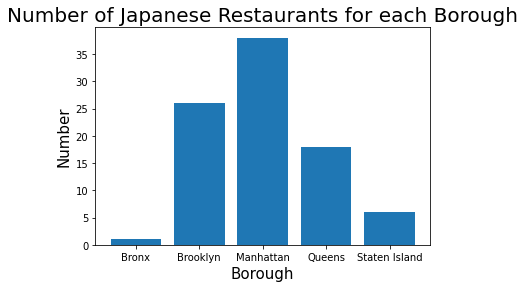

In [39]:
borough = ['Bronx','Brooklyn','Manhattan','Queens','Staten Island']
plt.bar(borough, Number)
plt.title('Number of Japanese Restaurants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Number', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()